In [195]:
import snap
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [127]:
def summary_compression_plot(df: pd.DataFrame, scatter_plots_args: list[dict]):
    """"Makes scatterplots from the dataframe and scatter plots arguments given
    in scatter_plots_args.

    Args:
        df (pd.DataFrame): The dataframe in question.
        scatter_plots_args (list[dict]): A list of dictionaries, where each
            dictionary contains the arguments 'x', 'y', and 'hue' for the 
            scatterplot.
    """
    no_graphs = len(scatter_plots_args)
    no_cols = 3
    no_rows = math.ceil(no_graphs / no_cols)
    f, axs = plt.subplots(nrows=no_rows, ncols=no_cols, figsize=(
        5*no_cols, 4*no_rows))
    for idx, args in enumerate(scatter_plots_args):
        df = df.sort_values(by=[args['x']], key=pd.to_numeric)
        row = math.floor(idx/no_cols)
        col = idx % no_cols
        axs_idx = ((no_cols - 1)*row + row + col)
        g = sns.scatterplot(
            data=df, x=args['x'], y=args['y'], hue=args['hue'], ax=axs.flatten()[axs_idx])
        g.yaxis.set_major_formatter(mtick.PercentFormatter())
    f.tight_layout()
    plt.show()

def summary_data_cleaning(filepath: str, is_labeled: bool):
    df = pd.read_csv(filepath)
    for column in df:
        drop_words: list[str] = ['Sketch', 'time', 'degree']
        if any(word in column for word in drop_words):
            df.drop(column, axis=1, inplace=True)
    
    if is_labeled:
        merge_types = [' is_target_merge=True', ' is_target_merge=False']
    else: 
        merge_types = ['']

    scatter_plots_args: list[dict] = []
    df['Network'] = df['Network'].map(lambda x: str(x).removesuffix('.txt'))
    df['Total size'] =  df['No. nodes'] + df['No. edges']
    for merge_type in merge_types:    
        df['CR edges'+merge_type] =  df['Summary no. edges'+merge_type] / df['No. edges'] * 100
        df['CR nodes'+merge_type] =  df['Summary no. nodes'+merge_type] / df['No. nodes'] * 100
        df['Total summary size'+merge_type] =  df['Summary no. nodes'+merge_type] + df['Summary no. edges'+merge_type]
        df['Total CR'+merge_type] =  df['Total summary size'+merge_type] / df['Total size'] * 100

        scatter_plots_args.extend([
            {'x': "No. nodes", 'y': "CR nodes"+merge_type, 'hue': "Network"},
            {'x': "No. edges", 'y': "CR edges"+merge_type, 'hue': "Network"},
            {'x': "Total size", 'y': "Total CR"+merge_type, 'hue': "Network"}
        ])
    # we convert them to ints because they are always ints and we don't need .0
    # we convert them to str because we don't want the x-axis to be treated as 
    # an int, we want them evently spaced
    df["No. nodes"] =  df["No. nodes"].astype(int).astype(str)
    df["No. edges"] =  df["No. edges"].astype(int).astype(str)
    df["Total size"] =  df["Total size"].astype(int).astype(str)
    
    summary_compression_plot(df, scatter_plots_args)


results/v1-results/2021-10-25_08h42m14s_soc-Epinions1.txt_node_results_N=1000.csv
results/v1-results/2021-10-25_08h42m14s_wiki-Vote.txt_node_results_N=1000.csv
results/v1-results/2021-10-25_08h42m14s_web-Stanford.txt_node_results_N=1000.csv
results/v1-results/2021-10-25_08h42m14s_twitter_combined.txt_node_results_N=1000.csv
results/v1-results/2021-10-25_08h42m14s_web-NotreDame.txt_node_results_N=1000.csv


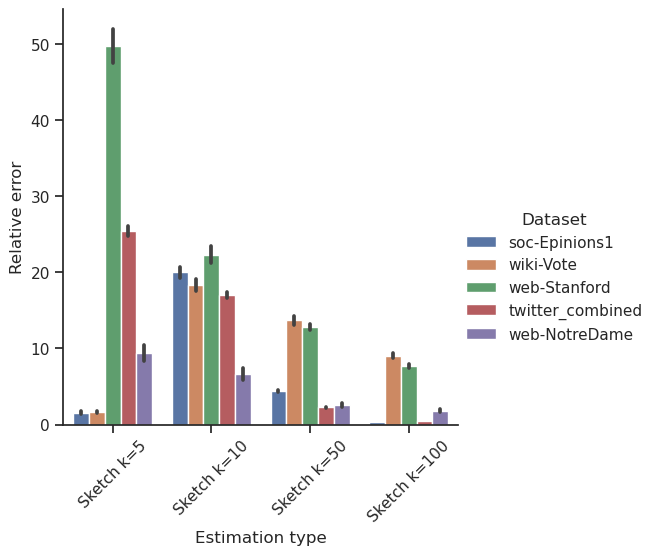

In [220]:
def results_sketch_bar_plot(results_folder_path: str, plot_separate: bool, plot_combined: bool):
    filepaths: list[str] = []
    for root, dirs, files in os.walk(results_folder_path):
        for file in files:
            if "node_results" in file:
                path = os.path.join(root, file)
                filepaths.append(path)
    
    df_combined = pd.DataFrame()
    for filepath in filepaths:
        df = pd.read_csv(filepath)
        df.drop('Function', axis=1, inplace=True)
        df.drop('Summary', axis=1, inplace=True)
        df.drop(df.tail(1).index,inplace=True) # we don't need the sum row
        df = df.melt(id_vars=['Node ids', 'TC'], var_name='Estimation type', value_name='Estimate')
        df['Relative error'] = ((df['Estimate'] - df['TC']) / df['TC']).abs() * 100    
        dataset = re.search(r'_[a-zA-Z0-9]+_(.+?).txt', filepath).group(1)
        df['Dataset'] = dataset
        df_combined = df_combined.append(df)
        if plot_separate:
            sns.barplot(x="Estimation type", y="Relative error", estimator=np.mean, data=df) # hue="smoker"
            plt.xticks(rotation=45)
            plt.show()
    
    if plot_combined:
        # print(np.unique(df_combined['Dataset']))
        sns.catplot(x="Estimation type", y="Relative error", hue="Dataset", kind="bar", estimator=np.mean, data=df_combined)
        plt.xticks(rotation=45)
        plt.show()

results_folder_path: str = "results/v1-results"
results_sketch_bar_plot(results_folder_path, False, True)


In [ ]:
unlabeled_filepath: str = 'results/v1-results/2021-10-25_08h42m14s_results_N=1000.csv'
summary_data_cleaning(unlabeled_filepath, False)
# labeled_filepath: str = 'results/2021-10-23_13h26m51s_results_N=1000.csv'
# summary_data_cleaning(labeled_filepath, True)

                Network  No. nodes  No. edges  No. zero degree  Max degree  \
0         wiki-Vote.txt     7115.0   103689.0              0.0      1167.0   
1     soc-Epinions1.txt    75879.0   508837.0              0.0      3079.0   
2     web-NotreDame.txt   325729.0  1497134.0              0.0     10721.0   
4  twitter_combined.txt    81306.0  2420766.0              0.0     10336.0   
3      web-Stanford.txt   281903.0  2312497.0              0.0     38626.0   
5        amazon0601.txt   403394.0  3387388.0              0.0      2761.0   
6        web-Google.txt   875713.0  5105039.0              0.0      6353.0   

   Loading time      TC time  Sketch creation time k=5  \
0      0.039379    10.701734                  0.052671   
1      0.392679   145.504761                  0.511182   
2      0.942624    93.961723                  1.022343   
4      1.415103   840.435263                  1.124508   
3      1.605198   515.783376                  3.166275   
5      3.510937  1513.19949

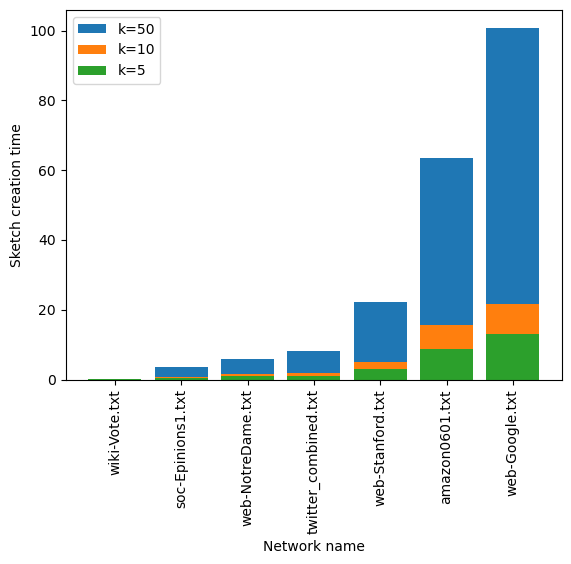

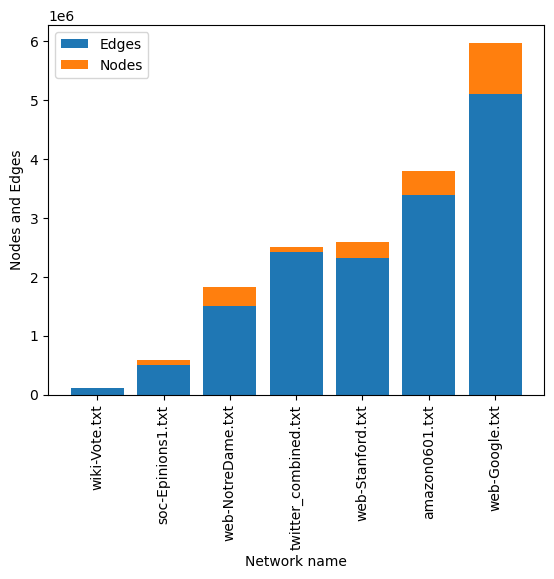

In [33]:
filepath = 'results/2021-10-22_07h24m49s_results_N=1000.csv'
results = pd.read_csv(filepath)

results['Sum'] = results['No. nodes'] + results['No. edges']
results['Sketch creation time k=5'] = results['Sketch creation time k=5'] / 60
results['Sketch creation time k=10'] = results['Sketch creation time k=10'] / 60
results['Sketch creation time k=50'] = results['Sketch creation time k=50'] / 60
results = results.sort_values('Sum')
print(results)

fig, ax = plt.subplots()
ax.bar(results['Network'], results['Sketch creation time k=50'], label='k=50')
ax.bar(results['Network'], results['Sketch creation time k=10'], label='k=10')
ax.bar(results['Network'], results['Sketch creation time k=5'], label='k=5')
ax.set_xlabel("Network name")
ax.set_ylabel("Sketch creation time (min)")
ax.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots()
ax.bar(results['Network'], results['No. edges'], label='Edges')
ax.bar(results['Network'], results['No. nodes'], label='Nodes', bottom=results['No. edges'])
ax.set_xlabel('Network name')
ax.set_ylabel('Nodes and Edges')
ax.legend(loc='best')
plt.xticks(rotation=90)
plt.show()